# Titanic Survival Prediction using Decision Trees

## Kaggle's Titanic Machine Learning Challenge

The Titanic dataset is one of the most popular machine learning challenges on Kaggle. In this analysis, we'll predict passenger survival using **Decision Tree algorithms**.

**Challenge Goal**: Predict which passengers survived the Titanic shipwreck based on features like age, gender, ticket class, etc.

**Why Decision Trees?**
- Easy to interpret and visualize
- No need for feature scaling
- Handle both numerical and categorical data
- Can capture non-linear relationships
- Provide feature importance rankings


In [201]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Data Loading and Initial Exploration

First, let's load the Titanic dataset. We'll use the built-in dataset from seaborn for this analysis.


In [202]:
# Load the Titanic dataset
df = pd.read_csv('train.csv')

# update the column names to be lowercase
df.columns = df.columns.str.lower()

# print the dataset shape
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head())

print("\n" + "="*50)
print("DATASET INFO")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
print(df.isnull().sum())

print("\n" + "="*50)
print("BASIC STATISTICS")
print("="*50)
print(df.describe())


Dataset Shape: (891, 12)

DATASET OVERVIEW
   passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0    

## 2. Exploratory Data Analysis (EDA)

Let's explore the data to understand the relationships between features and survival rates.


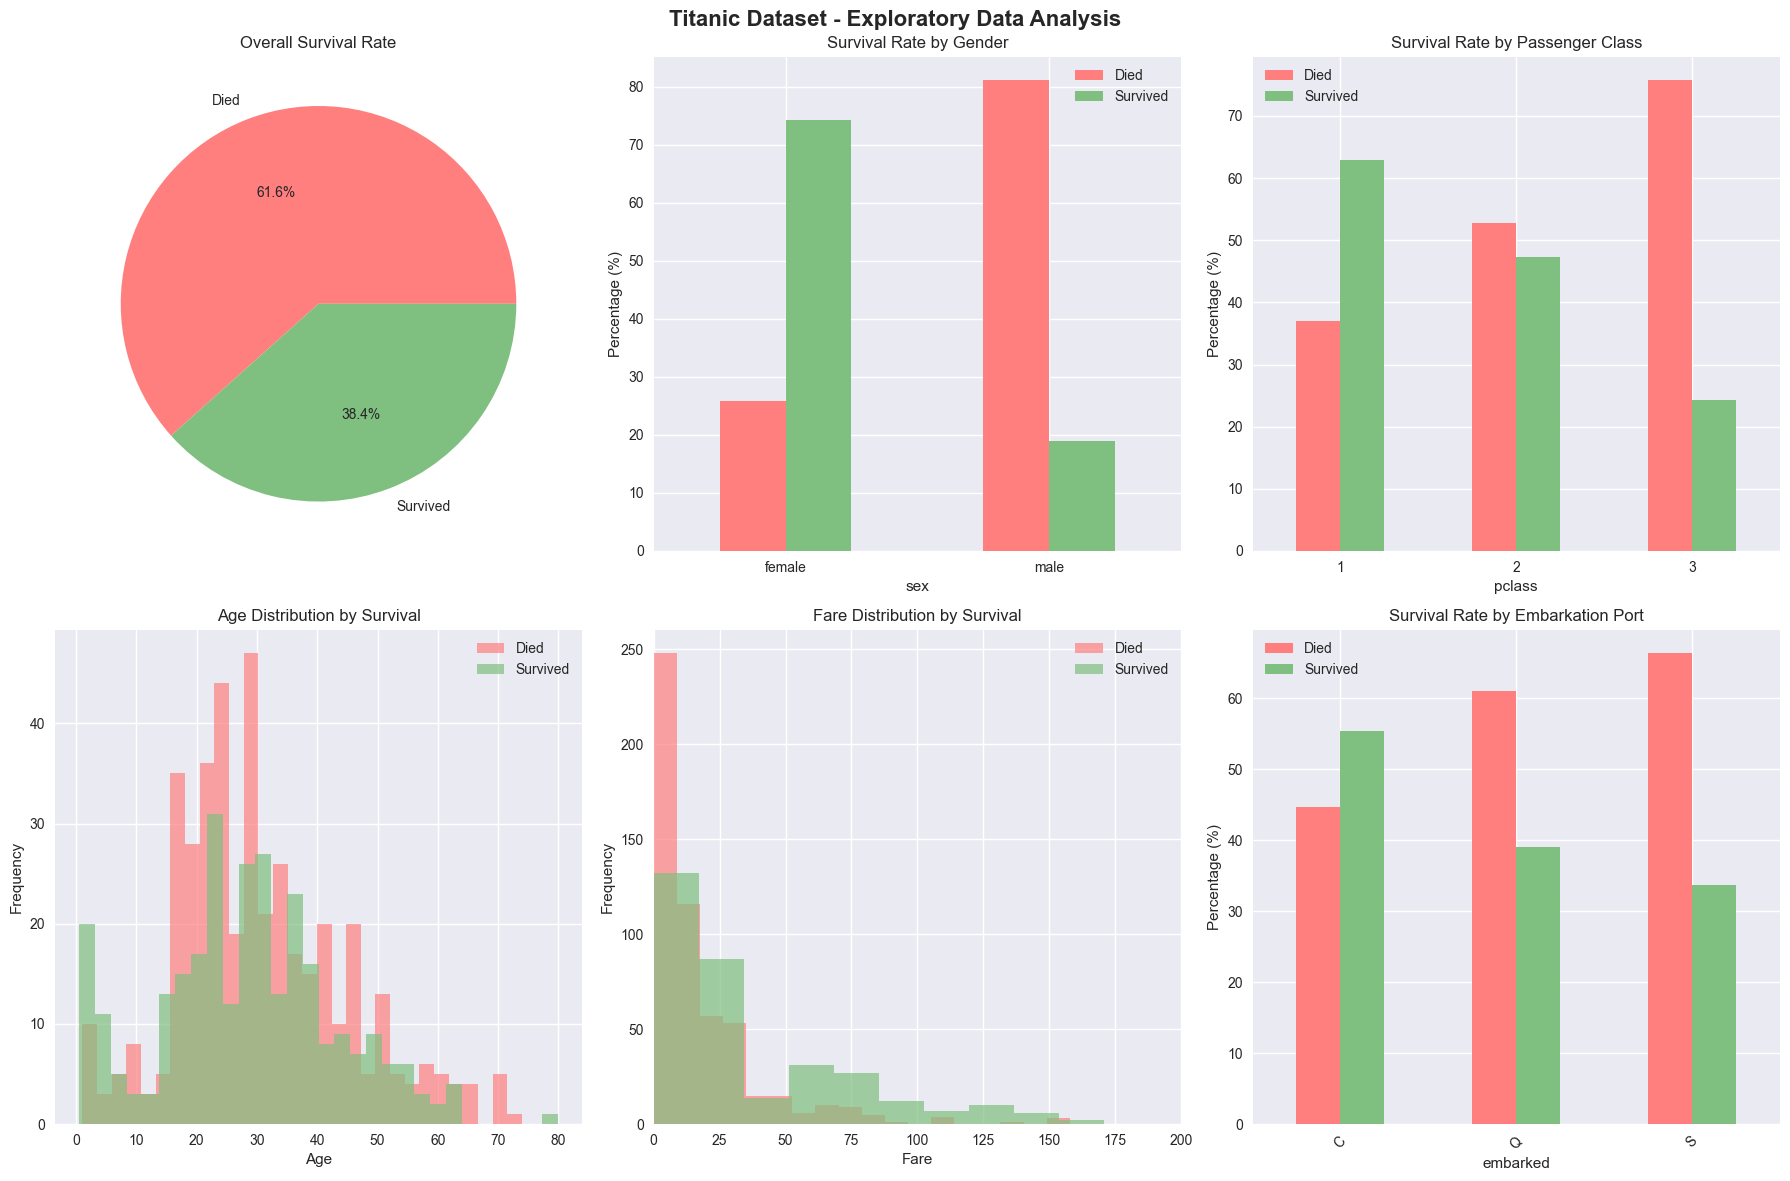

In [203]:
# Create a comprehensive EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Titanic Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Survival Rate
survival_counts = df['survived'].value_counts()
axes[0, 0].pie(survival_counts.values, labels=['Died', 'Survived'], autopct='%1.1f%%', 
               colors=['#ff7f7f', '#7fbf7f'])
axes[0, 0].set_title('Overall Survival Rate')

# 2. Survival by Gender
survival_by_sex = pd.crosstab(df['sex'], df['survived'], normalize='index') * 100
survival_by_sex.plot(kind='bar', ax=axes[0, 1], color=['#ff7f7f', '#7fbf7f'])
axes[0, 1].set_title('Survival Rate by Gender')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(['Died', 'Survived'])
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Survival by Passenger Class
survival_by_class = pd.crosstab(df['pclass'], df['survived'], normalize='index') * 100
survival_by_class.plot(kind='bar', ax=axes[0, 2], color=['#ff7f7f', '#7fbf7f'])
axes[0, 2].set_title('Survival Rate by Passenger Class')
axes[0, 2].set_ylabel('Percentage (%)')
axes[0, 2].legend(['Died', 'Survived'])
axes[0, 2].tick_params(axis='x', rotation=0)

# 4. Age Distribution by Survival
df[df['survived'] == 0]['age'].hist(bins=30, alpha=0.7, label='Died', ax=axes[1, 0], color='#ff7f7f')
df[df['survived'] == 1]['age'].hist(bins=30, alpha=0.7, label='Survived', ax=axes[1, 0], color='#7fbf7f')
axes[1, 0].set_title('Age Distribution by Survival')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 5. Fare Distribution by Survival
df[df['survived'] == 0]['fare'].hist(bins=30, alpha=0.7, label='Died', ax=axes[1, 1], color='#ff7f7f')
df[df['survived'] == 1]['fare'].hist(bins=30, alpha=0.7, label='Survived', ax=axes[1, 1], color='#7fbf7f')
axes[1, 1].set_title('Fare Distribution by Survival')
axes[1, 1].set_xlabel('Fare')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 200)  # Limit x-axis for better visualization

# 6. Survival by Embarkation Port
survival_by_embark = pd.crosstab(df['embarked'], df['survived'], normalize='index') * 100
survival_by_embark.plot(kind='bar', ax=axes[1, 2], color=['#ff7f7f', '#7fbf7f'])
axes[1, 2].set_title('Survival Rate by Embarkation Port')
axes[1, 2].set_ylabel('Percentage (%)')
axes[1, 2].legend(['Died', 'Survived'])
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


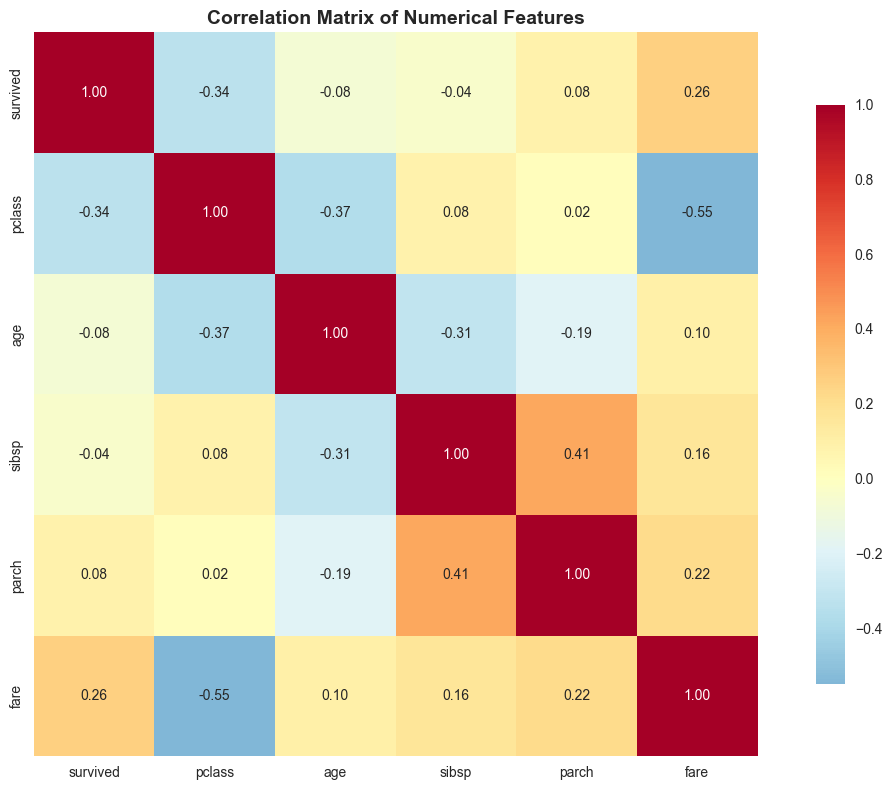

KEY INSIGHTS FROM EDA:
• Overall survival rate: 38.4%
• Female survival rate: 74.2%
• Male survival rate: 18.9%
• First class survival rate: 63.0%
• Third class survival rate: 24.2%
• Children (≤12) survival rate: 58.0%
• Adults (>12) survival rate: 38.8%


In [204]:
# Create a correlation heatmap
plt.figure(figsize=(12, 8))

# Select numerical columns for correlation
numeric_cols = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']
correlation_matrix = df[numeric_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})

plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print key insights
print("KEY INSIGHTS FROM EDA:")
print("="*50)
print(f"• Overall survival rate: {df['survived'].mean():.1%}")
print(f"• Female survival rate: {df[df['sex'] == 'female']['survived'].mean():.1%}")
print(f"• Male survival rate: {df[df['sex'] == 'male']['survived'].mean():.1%}")
print(f"• First class survival rate: {df[df['pclass'] == 1]['survived'].mean():.1%}")
print(f"• Third class survival rate: {df[df['pclass'] == 3]['survived'].mean():.1%}")
print(f"• Children (≤12) survival rate: {df[df['age'] <= 12]['survived'].mean():.1%}")
print(f"• Adults (>12) survival rate: {df[df['age'] > 12]['survived'].mean():.1%}")


## 3. Data Preprocessing

Now let's prepare the data for our decision tree model by handling missing values and encoding categorical variables.


In [205]:
# Create Ticket Group Features
def create_ticket_features(df_processed):

    # Ticket features
    # Clean and standardize ticket numbers
    df_processed['ticket_clean'] = df_processed['ticket'].str.strip().str.upper()

    # Extract ticket prefix and number
    ticket_pattern = r'^([A-Z./\s]+)\s*(\d+)$|^(\d+)$'
    df_processed['ticket_prefix'] = df_processed['ticket_clean'].str.extract(ticket_pattern)[0]
    df_processed['ticket_number'] = df_processed['ticket_clean'].str.extract(ticket_pattern)[1]

    # Handle purely numeric tickets
    numeric_mask = df_processed['ticket_clean'].str.match(r'^\d+$')
    df_processed.loc[numeric_mask, 'ticket_prefix'] = 'NUMERIC'
    df_processed.loc[numeric_mask, 'ticket_number'] = df_processed.loc[numeric_mask, 'ticket_clean']
    
    # Clean prefix and number
    df_processed['ticket_prefix'] = df_processed['ticket_prefix'].fillna('OTHER').str.strip()
    df_processed['ticket_number'] = df_processed['ticket_number'].fillna(0)

    # Group Analysis by Complete Ticket
    group_basic = df_processed.groupby('ticket_clean').agg({
        'passengerid': 'count',
        'fare': ['sum', 'mean', 'first'],
        'pclass': ['first', 'min', 'max'],
        'sex': lambda x: list(x),
        'age': ['mean', 'min', 'max'] 
    }).round(3)

    # Flatten column names
    group_basic.columns = ['_'.join(col).strip() for col in group_basic.columns]
    group_basic = group_basic.reset_index()

    if 'survived' in df_processed.columns:
        group_survival = df_processed.groupby('ticket_clean').agg({
            'survived': ['sum', 'mean', 'count']
        }).round(3)
        group_survival.columns = ['_'.join(col).strip() for col in group_survival.columns]
        group_survival = group_survival.reset_index()
        
        # Merge survival stats with basic stats
        ticket_groups = group_basic.merge(group_survival, on='ticket_clean', how='left')
    else:
        ticket_groups = group_basic

    # Group size
    df_processed['ticket_group_size'] = df_processed['ticket_clean'].map(
        ticket_groups.set_index('ticket_clean')['passengerid_count']
    )

    # Fare Analysis
    df_processed['total_ticket_fare'] = df_processed['ticket_clean'].map(
        ticket_groups.set_index('ticket_clean')['fare_sum']
    )
    df_processed['fare_per_person'] = df_processed['total_ticket_fare'] / df_processed['ticket_group_size']
    df_processed['fare_per_person'] = df_processed['fare_per_person'].replace(0, np.nan).fillna(df_processed['fare'])
    df_processed['fare_vs_individual'] = df_processed['fare'] / df_processed['fare_per_person']  # Should be ~1 for shared tickets

    # Group survival rate for training data
    if 'survived' in df_processed.columns:
        df_processed['group_survival_rate'] = df_processed['ticket_clean'].map(
            ticket_groups.set_index('ticket_clean')['survived_mean']
        )
        df_processed['group_survivors'] = df_processed['ticket_clean'].map(
            ticket_groups.set_index('ticket_clean')['survived_sum']
        )
        df_processed['group_deaths'] = df_processed['ticket_group_size'] - df_processed['group_survivors']
    
    # Group Composition Features
    df_processed['is_shared_ticket'] = (df_processed['ticket_group_size'] > 1).astype(int)
    df_processed['large_group'] = (df_processed['ticket_group_size'] >= 4).astype(int)
    df_processed['medium_group'] = (df_processed['ticket_group_size'].between(2, 3)).astype(int)
    df_processed['solo_traveler'] = (df_processed['ticket_group_size'] == 1).astype(int)

    # Group ticket by gender
    def analyze_group_gender(ticket):
        group_data = df_processed[df_processed['ticket_clean'] == ticket]
        unique_genders = group_data['sex'].nunique()
        return {
            'mixed_gender_group': 1 if unique_genders > 1 else 0,
            'all_male_group': 1 if unique_genders == 1 and group_data['sex'].iloc[0] == 'male' else 0,
            'all_female_group': 1 if unique_genders == 1 and group_data['sex'].iloc[0] == 'female' else 0
        }   
    
    gender_analysis = df_processed['ticket_clean'].map(analyze_group_gender)
    df_processed['mixed_gender_group'] = [g['mixed_gender_group'] for g in gender_analysis]
    df_processed['all_male_group'] = [g['all_male_group'] for g in gender_analysis]
    df_processed['all_female_group'] = [g['all_female_group'] for g in gender_analysis]
    
    # Age group dynamics
    def analyze_group_ages(ticket):
        group_data = df_processed[df_processed['ticket_clean'] == ticket]
        ages = group_data['age'].dropna()
        if len(ages) == 0:
            return {'has_children': 0, 'has_elderly': 0, 'age_span': 0}
        
        return {
            'has_children': 1 if (ages <= 12).any() else 0,
            'has_elderly': 1 if (ages >= 60).any() else 0, 
            'age_span': ages.max() - ages.min() if len(ages) > 1 else 0
        }
    
    age_analysis = df_processed['ticket_clean'].map(analyze_group_ages)
    df_processed['group_has_children'] = [a['has_children'] for a in age_analysis]
    df_processed['group_has_elderly'] = [a['has_elderly'] for a in age_analysis]
    df_processed['group_age_span'] = [a['age_span'] for a in age_analysis]
    
    # Ticket prefix survival rate
    prefix_survival = df_processed.groupby('ticket_prefix')['survived'].mean() if 'survived' in df_processed.columns else None
    popular_prefixes = df_processed['ticket_prefix'].value_counts()

    # Premium ticket prefixes (first class tickets often have specific prefixes)
    premium_prefixes = ['PC', 'STON/O', 'W./C.', 'W/C', 'A/5', 'S.O.C.']
    df_processed['premium_ticket_prefix'] = df_processed['ticket_prefix'].isin(premium_prefixes).astype(int)
    df_processed['numeric_ticket'] = (df_processed['ticket_prefix'] == 'NUMERIC').astype(int)

    # Class consistency in the group
    df_processed['group_class_consistency'] = df_processed['ticket_clean'].map(
        ticket_groups.set_index('ticket_clean')['pclass_min'] == 
        ticket_groups.set_index('ticket_clean')['pclass_max']
    ).astype(int)

    # Position within group based on birth order
    df_processed = df_processed.sort_values(['ticket_clean', 'age'])
    df_processed['position_in_group'] = df_processed.groupby('ticket_clean').cumcount() + 1
    df_processed['is_group_leader'] = (df_processed['position_in_group'] == 1).astype(int)  # Oldest in group
    
    print(f"✅ Ticket group features created:")
    print(f"   • Analyzed {df_processed['ticket_clean'].nunique()} unique tickets")
    print(f"   • Average group size: {df_processed['ticket_group_size'].mean():.2f}")
    print(f"   • Shared tickets: {df_processed['is_shared_ticket'].sum()} passengers")
    print(f"   • Solo travelers: {df_processed['solo_traveler'].sum()} passengers")
    print(f"   • Large groups (4+): {df_processed['large_group'].sum()} passengers")

    return df_processed
    
    

In [206]:
def create_name_complexity_features(df):
    """
    Create features based on name length and complexity indicating social status
    """
    print("Creating name complexity features...")
    
    # 1. Basic Name Length Features
    df['name_length'] = df['name'].str.len()
    df['name_word_count'] = df['name'].str.split().str.len()
    
    # 2. Name Structure Analysis
    # Count commas (indicates formal structure: "Last, Title First Middle")
    df['name_comma_count'] = df['name'].str.count(',')
    
    # Count periods (indicates titles, initials, abbreviations)
    df['name_period_count'] = df['name'].str.count(r'\.')
    
    # Count parentheses (indicates maiden names, aliases, additional info)
    df['name_parentheses_count'] = df['name'].str.count(r'\(') + df['name'].str.count(r'\)')
    
    # 3. Social Status Indicators in Names
    # Nobility and high-status titles
    nobility_titles = [
        'Countess', 'Lady', 'Sir', 'Lord', 'Baron', 'Duke', 'Duchess', 
        'Earl', 'Marquis', 'Viscountess', 'Princess', 'Prince', 'Count'
    ]
    df['has_nobility_title'] = df['name'].str.contains('|'.join(nobility_titles), case=False, na=False).astype(int)
    
    # Professional titles indicating education/status
    professional_titles = [
        'Dr', 'Professor', 'Prof', 'Colonel', 'Col', 'Major', 'Captain', 
        'Capt', 'Lieutenant', 'Lt', 'Reverend', 'Rev', 'Engineer'
    ]
    df['has_professional_title'] = df['name'].str.contains('|'.join(professional_titles), case=False, na=False).astype(int)
    
    # 4. Middle Names and Initials (indicating completeness of formal name)
    # Extract the part after comma and before parentheses for analysis
    df['formal_name_part'] = df['name'].str.split(',').str[1].str.split('(').str[0]
    
    # Count potential middle names/initials
    df['middle_name_count'] = df['formal_name_part'].str.split().str.len() - 2  # Subtract title and first name
    df['middle_name_count'] = df['middle_name_count'].clip(lower=0)  # No negative values
    
    # Single initials vs full middle names (initials might indicate abbreviated wealthy names)
    df['has_middle_initials'] = df['formal_name_part'].str.contains(r'\b[A-Z]\.\s', na=False).astype(int)
    
    # 5. Name Complexity Score (composite indicator)
    # Weighted score combining multiple factors
    df['name_complexity_score'] = (
        df['name_length'] * 0.1 +                    # Length contributes
        df['name_word_count'] * 2 +                  # More words = more formal
        df['name_comma_count'] * 3 +                 # Formal structure
        df['name_period_count'] * 1.5 +              # Titles and initials
        df['has_nobility_title'] * 10 +              # Nobility = high status
        df['has_professional_title'] * 5 +           # Professional status
        df['middle_name_count'] * 2 +                # Multiple middle names
        df['has_middle_initials'] * 3                # Formal initials
    )
    
    # 6. Name Length Categories
    # Based on name length distribution
    name_length_percentiles = df['name_length'].quantile([0.25, 0.5, 0.75]).values
    df['name_length_category'] = pd.cut(
        df['name_length'], 
        bins=[0] + list(name_length_percentiles) + [float('inf')],
        labels=['short', 'medium', 'long', 'very_long']
    )
    
    # 7. Unusual Name Patterns (might indicate foreign aristocracy)
    # Multiple consecutive capitals (might indicate compound surnames)
    df['has_compound_surname'] = df['name'].str.contains(r'[A-Z][a-z]+[A-Z]', na=False).astype(int)
    
    # Names with "de", "von", "van" etc. (aristocratic indicators)
    aristocratic_particles = ['de ', 'von ', 'van ', 'du ', 'la ', 'le ', 'del ', 'della ']
    df['has_aristocratic_particle'] = df['name'].str.contains(
        '|'.join(aristocratic_particles), case=False, na=False
    ).astype(int)
    
    print(f"✅ Name complexity features created:")
    print(f"   • Average name length: {df['name_length'].mean():.1f} characters")
    print(f"   • Names with nobility titles: {df['has_nobility_title'].sum()}")
    print(f"   • Names with professional titles: {df['has_professional_title'].sum()}")
    print(f"   • Names with aristocratic particles: {df['has_aristocratic_particle'].sum()}")
    print(f"   • Average complexity score: {df['name_complexity_score'].mean():.2f}")
    
    return df

# Example usage and analysis
def analyze_name_complexity_survival(df):
    """
    Analyze relationship between name complexity and survival
    """
    if 'survived' in df.columns:
        print(f"\n📊 NAME COMPLEXITY vs SURVIVAL:")
        
        # Survival by name length category
        name_survival = df.groupby('name_length_category')['survived'].mean()
        print(f"Survival by name length:")
        for category, survival_rate in name_survival.items():
            print(f"   {category}: {survival_rate:.1%}")
        
        # Survival by social status indicators
        if df['has_nobility_title'].sum() > 0:
            nobility_survival = df.groupby('has_nobility_title')['survived'].mean()
            print(f"Nobility title survival: {nobility_survival[1]:.1%} vs {nobility_survival[0]:.1%}")
        
        # Survival by complexity score quartiles
        complexity_quartiles = pd.qcut(df['name_complexity_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        complexity_survival = df.groupby(complexity_quartiles)['survived'].mean()
        print(f"Survival by name complexity quartiles:")
        for quartile, survival_rate in complexity_survival.items():
            print(f"   {quartile}: {survival_rate:.1%}")

In [207]:
def create_embarkation_context_features(df):
    """
    Create features based on embarkation port context and wealth indicators
    """
    print("Creating embarkation context features...")
    
    # 1. Port Background Information
    port_context = {
        'S': {  # Southampton, England - Main British port
            'wealth_level': 'medium',
            'passenger_class_mix': 'mixed',
            'distance_to_destination': 'short',
            'port_size': 'large',
            'typical_fare_level': 'medium'
        },
        'C': {  # Cherbourg, France - Wealthy European passengers
            'wealth_level': 'high',
            'passenger_class_mix': 'first_class_heavy',
            'distance_to_destination': 'medium', 
            'port_size': 'medium',
            'typical_fare_level': 'high'
        },
        'Q': {  # Queenstown (Cobh), Ireland - Poor Irish emigrants
            'wealth_level': 'low',
            'passenger_class_mix': 'third_class_heavy',
            'distance_to_destination': 'medium',
            'port_size': 'small',
            'typical_fare_level': 'low'
        }
    }
    
    # 2. Wealth Level by Port
    port_wealth_mapping = {'S': 2, 'C': 3, 'Q': 1}  # Ordinal: 1=low, 2=medium, 3=high
    df['embark_wealth_level'] = df['embarked'].map(port_wealth_mapping).fillna(2)  # Default medium
    
    # 3. Port Size and Infrastructure
    port_size_mapping = {'S': 3, 'C': 2, 'Q': 1}  # 1=small, 2=medium, 3=large
    df['embark_port_size'] = df['embarked'].map(port_size_mapping).fillna(2)
    
    # 4. Expected Passenger Class by Port
    # Cherbourg = wealthy, Queenstown = poor, Southampton = mixed
    df['is_cherbourg'] = (df['embarked'] == 'C').astype(int)  # Wealthy European port
    df['is_queenstown'] = (df['embarked'] == 'Q').astype(int)  # Poor Irish port
    df['is_southampton'] = (df['embarked'] == 'S').astype(int)  # Mixed British port
    
    # 5. Port-Class Consistency Features
    # These capture whether passenger's class matches typical port demographics
    
    # Cherbourg expectations (should be first/second class)
    df['cherbourg_class_match'] = 0
    df.loc[(df['embarked'] == 'C') & (df['pclass'].isin([1, 2])), 'cherbourg_class_match'] = 1
    df.loc[(df['embarked'] == 'C') & (df['pclass'] == 1), 'cherbourg_class_match'] = 2  # Perfect match
    
    # Queenstown expectations (should be third class)  
    df['queenstown_class_match'] = 0
    df.loc[(df['embarked'] == 'Q') & (df['pclass'] == 3), 'queenstown_class_match'] = 1
    
    # Southampton (mixed, so any class is normal)
    df['southampton_class_match'] = 1  # Always matches (mixed port)
    df.loc[df['embarked'] != 'S', 'southampton_class_match'] = 0
    
    # 6. Port-Fare Consistency
    # Calculate expected fare ranges by port and class
    if 'fare' in df.columns:
        port_fare_stats = df.groupby(['embarked', 'pclass'])['fare'].agg(['mean', 'std']).round(2)
        
        # Flag passengers with unusually high/low fares for their port
        df['fare_vs_port_expectation'] = 0
        
        for port in ['S', 'C', 'Q']:
            for pclass in [1, 2, 3]:
                mask = (df['embarked'] == port) & (df['pclass'] == pclass)
                if mask.sum() > 0:
                    try:
                        expected_fare = port_fare_stats.loc[(port, pclass), 'mean']
                        fare_std = port_fare_stats.loc[(port, pclass), 'std']
                        
                        # Compare actual vs expected fare
                        fare_ratio = df.loc[mask, 'fare'] / expected_fare
                        df.loc[mask, 'fare_vs_port_expectation'] = fare_ratio
                    except (KeyError, ZeroDivisionError):
                        df.loc[mask, 'fare_vs_port_expectation'] = 1.0  # Normal
        
        # Cap extreme values
        df['fare_vs_port_expectation'] = df['fare_vs_port_expectation'].clip(0.1, 5.0)
        
        # Binary features for unusual fare patterns
        df['overpaid_for_port'] = (df['fare_vs_port_expectation'] > 1.5).astype(int)
        df['underpaid_for_port'] = (df['fare_vs_port_expectation'] < 0.7).astype(int)
    
    # 7. Cultural/Regional Context
    # European vs British vs Irish cultural background
    df['european_embarkation'] = (df['embarked'] == 'C').astype(int)  # Continental European
    df['irish_embarkation'] = (df['embarked'] == 'Q').astype(int)     # Irish
    df['british_embarkation'] = (df['embarked'] == 'S').astype(int)   # British
    
    # 8. Distance and Journey Context
    distance_mapping = {'S': 1, 'C': 2, 'Q': 2}  # Relative sailing distance to Titanic route
    df['embark_distance_factor'] = df['embarked'].map(distance_mapping).fillna(1)
    
    # 9. Port Social Network Effects
    # Passengers from same port might help each other (especially Irish from Queenstown)
    port_passenger_counts = df['embarked'].value_counts()
    df['port_passenger_count'] = df['embarked'].map(port_passenger_counts)
    df['large_port_group'] = (df['port_passenger_count'] > port_passenger_counts.median()).astype(int)
    
    print(f"✅ Embarkation context features created:")
    print(f"   • Southampton passengers: {df['is_southampton'].sum()}")
    print(f"   • Cherbourg passengers: {df['is_cherbourg'].sum()}")  
    print(f"   • Queenstown passengers: {df['is_queenstown'].sum()}")
    
    if 'fare' in df.columns:
        port_fare_summary = df.groupby('embarked')['fare'].mean()
        print(f"   • Average fares by port:")
        for port, avg_fare in port_fare_summary.items():
            port_name = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}.get(port, port)
            print(f"     {port_name}: ${avg_fare:.2f}")
    
    return df

def analyze_embarkation_patterns(df):
    """
    Analyze survival patterns by embarkation port
    """
    if 'survived' in df.columns:
        print(f"\n📊 EMBARKATION PORT ANALYSIS:")
        
        # Overall survival by port
        port_survival = df.groupby('embarked')['survived'].agg(['count', 'mean']).round(3)
        port_survival.columns = ['passenger_count', 'survival_rate']
        print(f"Survival by embarkation port:")
        for port, stats in port_survival.iterrows():
            port_name = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}.get(port, port)
            print(f"   {port_name}: {stats['survival_rate']:.1%} ({stats['passenger_count']} passengers)")
        
        # Survival by port and class
        port_class_survival = df.groupby(['embarked', 'pclass'])['survived'].mean().round(3)
        print(f"\nSurvival by port and class:")
        for (port, pclass), survival_rate in port_class_survival.items():
            port_name = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}.get(port, port)
            print(f"   {port_name} Class {pclass}: {survival_rate:.1%}")

In [208]:
# Preprocessing function that works for both train and test data
def preprocess_titanic_data(df, is_train=True):
    """
    Preprocess Titanic data for both training and test sets
    """
    df_processed = df.copy()

    # lowercase the column names
    df_processed.columns = df_processed.columns.str.lower()
    
    print(f"\n{'TRAINING' if is_train else 'TEST'} DATA PREPROCESSING:")
    print("="*50)
    print(f"Original shape: {df_processed.shape}")
    print(f"Missing values:\n{df_processed.isnull().sum()}")
    
    # 1. Handle missing values
    print(f"\n1. Handling Missing Values:")
    
    # Age: Fill with median age by passenger class and gender
    for pclass in df_processed['pclass'].unique():
        for sex in df_processed['sex'].unique():
            mask = (df_processed['pclass'] == pclass) & (df_processed['sex'] == sex)
            median_age = df_processed[mask]['age'].median()
            if pd.isna(median_age):  # If no data for this group, use overall median
                median_age = df_processed['age'].median()
            df_processed.loc[mask & df_processed['age'].isnull(), 'age'] = median_age
    
    # Embarked: Fill with mode (most common port)
    if 'embarked' in df_processed.columns:
        mode_embarked = df_processed['embarked'].mode()[0] if not df_processed['embarked'].mode().empty else 'S'
        df_processed['embarked'].fillna(mode_embarked, inplace=True)
        print(f"   • Embarked missing values filled with: {mode_embarked}")
    
    # Fare: Fill with median fare by passenger class
    if df_processed['fare'].isnull().any():
        for pclass in df_processed['pclass'].unique():
            mask = df_processed['pclass'] == pclass
            median_fare = df_processed[mask]['fare'].median()
            df_processed.loc[mask & df_processed['fare'].isnull(), 'fare'] = median_fare
        print(f"   • Fare missing values filled with class-specific medians")
    
    # Cabin: Extract deck information
    df_processed['deck'] = df_processed['cabin'].str[0] if 'cabin' in df_processed.columns else 'Unknown'
    df_processed['deck'].fillna('Unknown', inplace=True)

    
    # Print age processing summary
    age_missing_before = df['Age'].isnull().sum() if 'Age' in df.columns else df['age'].isnull().sum()
    print(f"   • Age missing values filled: {age_missing_before} → {df_processed['age'].isnull().sum()}")
    
    # 2. Feature Engineering
    print(f"\n2. Feature Engineering:")
    
    # Deck hierarchy features
    deck_hierarchy = {
        'A': 7,  # Most premium
        'B': 6,
        'C': 5, 
        'D': 4,
        'E': 3,
        'F': 2,
        'G': 1,  # Least premium
        'T': 0,  # Tank deck (very rare)
        'Unknown': 0  # Missing cabin info
    }

    deck_level_mapping = {
        'A': 'premium',    # A, B
        'B': 'premium',
        'C': 'upper',      # C, D  
        'D': 'upper',
        'E': 'lower',      # E, F, G
        'F': 'lower',
        'G': 'lower',
        'T': 'lower',
        'Unknown': 'unknown'
    }

    df_processed['deck_premium_score'] = df_processed['deck'].map(deck_hierarchy)
    df_processed['has_cabin_info'] = (df_processed['deck'] != 'Unknown').astype(int)
    df_processed['premium_deck'] = (df_processed['deck'].isin(['A', 'B'])).astype(int)
    df_processed['upper_deck'] = (df_processed['deck'].isin(['A', 'B', 'C', 'D'])).astype(int)
    df_processed['known_premium_deck'] = ((df_processed['deck'].isin(['A', 'B'])) & (df_processed['deck'] != 'Unknown')).astype(int)

    # Deck features interaction with class
    df_processed['deck_class_consistency'] = 0
    if 'pclass' in df_processed.columns:
        # First class should be on premium decks
        df_processed.loc[(df_processed['pclass'] == 1) & (df_processed['deck_premium_score'] == 7), 'deck_class_consistency'] = 2  # Perfect match
        df_processed.loc[(df_processed['pclass'] == 1) & (df_processed['deck_premium_score'] == 6), 'deck_class_consistency'] = 1   # Good match
        df_processed.loc[(df_processed['pclass'] == 3) & (df_processed['deck'].isin(['E', 'F', 'G'])), 'deck_class_consistency'] = 1  # Expected for 3rd class
    
    # Deck room features
    df_processed['room_number'] = df_processed['cabin'].str.extract('([0-9]+)', expand=False).astype(float)
    df_processed['room_number'].fillna(0, inplace=True)
        
    # Lower room numbers often indicate better positions
    df_processed['low_room_number'] = (df_processed['room_number'] <= 50).astype(int)
    
    
    # Family size features
    df_processed['family_size'] = df_processed['sibsp'] + df_processed['parch'] + 1
    df_processed['is_alone'] = (df_processed['family_size'] == 1).astype(int)

    # Family surname feature
    df_processed['family_surname'] = df_processed['name'].str.split(',').str[0].str.strip()
    
    # Clean up surnames (remove extra spaces, standardize)
    df_processed['family_surname'] = df_processed['family_surname'].str.upper().str.replace(r'\s+', ' ', regex=True)

    print(f"✅ Extracted {df_processed['family_surname'].nunique()} unique surnames")

    # Family total fare feature
    df_processed['family_total_fare'] = df_processed.groupby('family_surname')['fare'].transform('sum')
    
    # Age groups
    df_processed['age_group'] = pd.cut(df_processed['age'], 
                                     bins=[0, 12, 18, 35, 60, 100], 
                                     labels=['child', 'teen', 'young_adult', 'adult', 'senior'])
    
    # Fare groups
    df_processed['fare_group'] = pd.cut(df_processed['fare'], 
                                      bins=[0, 10, 20, 50, 100, 1000], 
                                      labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    
    # Title extraction from Name
    if 'name' in df_processed.columns:
        df_processed['title'] = df_processed['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        # Group rare titles
        title_mapping = {
            'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
            'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
            'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
            'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
            'Capt': 'Rare', 'Sir': 'Rare'
        }
        df_processed['title'] = df_processed['title'].map(title_mapping).fillna('rare')
    
    print(f"   • family_size: {df_processed['family_size'].min()} to {df_processed['family_size'].max()}")
    print(f"   • is_alone: {df_processed['is_alone'].sum()} passengers traveling alone")
    print(f"   • age_group: {df_processed['age_group'].value_counts().to_dict()}")
    print(f"   • title extracted from name column")

    # Create features based on name length and complexity indicating social status
    df_processed = create_name_complexity_features(df_processed)

    # Create features based on embarkation port context and wealth indicators
    df_processed = create_embarkation_context_features(df_processed)

    # Ticket features
    df_processed = create_ticket_features(df_processed)
    
    # 3. Encode categorical variables
    print(f"\n3. Encoding Categorical Variables:")
    
    # One-hot encoding for categorical features
    categorical_features = ['sex', 'embarked', 'deck', 'age_group', 'fare_group', 'title', 'cabin_class']
    
    for feature in categorical_features:
        if feature in df_processed.columns:
            # Convert to string to handle any remaining NaN values
            df_processed[feature] = df_processed[feature].astype(str)
            # Create dummy variables
            dummies = pd.get_dummies(df_processed[feature], prefix=feature)
            df_processed = pd.concat([df_processed, dummies], axis=1)
            print(f"   • {feature}: {len(dummies.columns)} categories encoded")
    
    print(f"\nAfter preprocessing:")
    print(f"Shape: {df_processed.shape}")
    total_missing = df_processed.isnull().sum().sum()
    print(f"Missing values: {total_missing}")
    
    # Show breakdown of any remaining missing valuess
    if total_missing > 0:
        missing_by_col = df_processed.isnull().sum()
        missing_cols = missing_by_col[missing_by_col > 0]
        if len(missing_cols) > 0:
            print(f"Remaining missing values by column:")
            for col, count in missing_cols.items():
                print(f"   • {col}: {count} missing")
            print(f"Note: Some missing values in encoded features are normal and will be handled during modeling.")
    
    return df_processed

# Preprocess both training and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Preprocess the data
train_processed = preprocess_titanic_data(train_df, is_train=True)
test_processed = preprocess_titanic_data(test_df, is_train=False)



TRAINING DATA PREPROCESSING:
Original shape: (891, 12)
Missing values:
passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

1. Handling Missing Values:
   • Embarked missing values filled with: S
   • Age missing values filled: 177 → 0

2. Feature Engineering:
✅ Extracted 667 unique surnames
   • family_size: 1 to 11
   • is_alone: 537 passengers traveling alone
   • age_group: {'young_adult': 514, 'adult': 216, 'teen': 70, 'child': 69, 'senior': 22}
   • title extracted from name column
Creating name complexity features...
✅ Name complexity features created:
   • Average name length: 27.0 characters
   • Names with nobility titles: 7
   • Names with professional titles: 66
   • Names with aristocratic particles: 30
   • Average complexity score: 17.09
Creating embarkation context features...
✅ Emba

## 4. Model Building with Decision Trees

Now let's build and train our decision tree models.


### Model Training and Comparison

Now let's train multiple decision tree models and compare their performance.


In [209]:
# Prepare features for modeling
print("\n" + "="*60)
print("PREPARING DATA FOR MODELING")
print("="*60)

# Select features that will work for both train and test sets
base_features = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'family_size' ]

# Add encoded categorical features (dummy variables)
encoded_features = []
for col in train_processed.columns:
    if any(col.startswith(prefix) for prefix in ['sex_', 'embarked_', 'deck_', 'age_group_', 'fare_group_', 'title_', 'ticket_prefix_', 'name_length_category_']):
        encoded_features.append(col)

# Add advanced numeric features
numeric_features = ['family_size', 'family_total_fare', 'deck_premium_score', 'deck_class_consistency', 'room_number']

# Add binary features with 0/1 values
binary_features = ['is_alone', 'has_cabin_info','premium_deck', 'upper_deck', 'known_premium_deck', 'low_room_number']

# Name complexity features
name_features = [
    'name_length',
    'name_word_count', 
    'name_complexity_score',
    'has_nobility_title',
    'has_professional_title',
    'middle_name_count',
    'has_aristocratic_particle'
]
    
# Embarkation context features  
port_features = [
    'embark_wealth_level',
    'is_cherbourg',
    'is_queenstown', 
    'cherbourg_class_match',
    'queenstown_class_match',
    'fare_vs_port_expectation',
    'overpaid_for_port',
    'european_embarkation'
]

# Ticket group features
ticket_features = [
    'ticket_group_size',           # Most important - group size
    'is_shared_ticket',            # Binary: traveling with others
    'fare_per_person',            # Economic: actual cost per person
    'mixed_gender_group',         # Family indicator
    'group_has_children',         # Protection behavior
    'large_group',                # Large family dynamics
    'solo_traveler',              # Individual vs group traveler
    'premium_ticket_prefix',      # Ticket class indicator
    'position_in_group',          # Birth order / leadership
    'group_age_span',             # Generational group
    'group_class_consistency',    # Economic consistency
]


# Combine all features
feature_columns = base_features + encoded_features + numeric_features + binary_features + ticket_features

# Ensure features exist in both train and test sets
train_features = [col for col in feature_columns if col in train_processed.columns]
test_features = [col for col in feature_columns if col in test_processed.columns]

# Use only features that exist in both datasets
final_features = list(set(train_features) & set(test_features))
final_features.sort()  # Sort for consistency


print(f" • Base features: {len(base_features)}")
print(f" • Name complexity features: {len(name_features)}")
print(f" • Embarkation context features: {len(port_features)}")
print(f" • Ticket group features: {len(ticket_features)}")
print(f" • Encoded features: {len(encoded_features)}")
print(f" • Final features for modeling: {len(final_features)}")
print(f" • All features: {sorted(final_features)}")



PREPARING DATA FOR MODELING
 • Base features: 6
 • Name complexity features: 7
 • Embarkation context features: 8
 • Ticket group features: 11
 • Encoded features: 32
 • Final features for modeling: 56
 • All features: ['age', 'age_group_adult', 'age_group_child', 'age_group_senior', 'age_group_teen', 'age_group_young_adult', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_Unknown', 'deck_class_consistency', 'deck_premium_score', 'embarked_C', 'embarked_Q', 'embarked_S', 'family_size', 'family_total_fare', 'fare', 'fare_group_high', 'fare_group_low', 'fare_group_medium', 'fare_group_nan', 'fare_group_very_high', 'fare_group_very_low', 'fare_per_person', 'group_age_span', 'group_class_consistency', 'group_has_children', 'has_cabin_info', 'is_alone', 'is_shared_ticket', 'known_premium_deck', 'large_group', 'low_room_number', 'mixed_gender_group', 'parch', 'pclass', 'position_in_group', 'premium_deck', 'premium_ticket_prefix', 'room_number', 'sex_female', 'sex

In [210]:
def decision_tree_optimized_selection(X_train, y_train, max_features=25):
    """
    Optimized feature selection specifically for Decision Tree classifiers
    """
    print("🌳 DECISION TREE OPTIMIZED FEATURE SELECTION")
    print("="*60)
    
    from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.feature_selection import SelectFromModel, mutual_info_classif
    from sklearn.model_selection import cross_val_score
    import numpy as np
    
    # Method 1: Extra Trees (best for tree-based selection)
    print("\n1️⃣ Extra Trees Feature Importance")
    extra_trees = ExtraTreesClassifier(
        n_estimators=100, 
        random_state=42,
        max_depth=None,  # Allow full depth for feature evaluation
        min_samples_split=5,
        min_samples_leaf=2
    )
    extra_trees.fit(X_train, y_train)
    
    # Get feature importances
    feature_importance = dict(zip(X_train.columns, extra_trees.feature_importances_))
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    
    # Select top features
    top_features_et = [f[0] for f in sorted_features[:max_features]]
    print(f"   ✅ Selected {len(top_features_et)} features")
    print(f"   🔝 Top 5: {top_features_et[:5]}")
    
    # Method 2: Mutual Information (captures non-linear relationships)
    print("\n2️⃣ Mutual Information Selection")
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
    mi_feature_scores = dict(zip(X_train.columns, mi_scores))
    sorted_mi = sorted(mi_feature_scores.items(), key=lambda x: x[1], reverse=True)
    
    top_features_mi = [f[0] for f in sorted_mi[:max_features]]
    print(f"   ✅ Selected {len(top_features_mi)} features")
    print(f"   🔝 Top 5: {top_features_mi[:5]}")
    
    # Method 3: Decision Tree RFE (most specific to DT)
    print("\n3️⃣ Decision Tree Recursive Feature Elimination")
    from sklearn.feature_selection import RFE
    
    dt_selector = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
    
    rfe = RFE(dt_selector, n_features_to_select=max_features, step=1)
    rfe.fit(X_train, y_train)
    
    top_features_rfe = X_train.columns[rfe.support_].tolist()
    print(f"   ✅ Selected {len(top_features_rfe)} features")
    print(f"   🔝 Top 5: {top_features_rfe[:5]}")
    
    # Method 4: Ensemble voting (combine all methods)
    print("\n4️⃣ Ensemble Voting")
    all_methods = {
        'extra_trees': top_features_et,
        'mutual_info': top_features_mi,
        'rfe': top_features_rfe
    }
    
    # Count votes
    feature_votes = {}
    for method, features in all_methods.items():
        for feature in features:
            feature_votes[feature] = feature_votes.get(feature, 0) + 1
    
    # Select features with at least 2 votes (majority)
    ensemble_features = [f for f, votes in feature_votes.items() if votes >= 2]
    
    # If too few, add top-voted single features
    if len(ensemble_features) < max_features:
        remaining_features = sorted(
            [f for f in feature_votes.items() if f[0] not in ensemble_features],
            key=lambda x: x[1], reverse=True
        )
        ensemble_features.extend([f[0] for f in remaining_features[:max_features-len(ensemble_features)]])
    
    ensemble_features = ensemble_features[:max_features]  # Trim to max
    
    print(f"   ✅ Selected {len(ensemble_features)} features")
    print(f"   🔝 Top 5: {ensemble_features[:5]}")
    
    # Test all methods with actual Decision Tree performance
    print("\n🧪 PERFORMANCE TESTING WITH DECISION TREE")
    print("-" * 40)
    
    dt_test = DecisionTreeClassifier(
        max_depth=8,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
    
    methods_to_test = {
        'Extra Trees': top_features_et,
        'Mutual Info': top_features_mi,
        'RFE': top_features_rfe,
        'Ensemble': ensemble_features
    }
    
    results = {}
    for method_name, features in methods_to_test.items():
        X_subset = X_train[features]
        scores = cross_val_score(dt_test, X_subset, y_train, cv=5, scoring='accuracy')
        results[method_name] = {
            'mean_score': scores.mean(),
            'std_score': scores.std(),
            'features': features,
            'n_features': len(features)
        }
        print(f"{method_name:12} | Features: {len(features):2d} | Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")
    
    # Return best method
    best_method = max(results.keys(), key=lambda k: results[k]['mean_score'])
    print(f"\n🏆 BEST METHOD: {best_method}")
    
    return results[best_method]['features'], results, feature_votes

# Progressive feature testing specifically for Decision Trees
def progressive_dt_feature_selection(X_train, y_train, start_features=None, max_features=30):
    """
    Progressive feature addition optimized for Decision Tree performance
    """
    print("\n🌳 PROGRESSIVE DECISION TREE FEATURE SELECTION")
    print("="*60)
    
    if start_features is None:
        # Start with most universally important features for Titanic
        start_features = [
            col for col in ['pclass', 'sex_female', 'age', 'fare', 'family_size'] 
            if col in X_train.columns
        ]
    
    # Get remaining features ranked by tree importance
    from sklearn.ensemble import ExtraTreesClassifier
    
    et = ExtraTreesClassifier(n_estimators=100, random_state=42)
    et.fit(X_train, y_train)
    
    feature_importance = dict(zip(X_train.columns, et.feature_importances_))
    remaining_features = [f for f in X_train.columns if f not in start_features]
    remaining_features.sort(key=lambda f: feature_importance[f], reverse=True)
    
    # Progressive testing
    current_features = start_features.copy()
    best_score = 0
    no_improvement_count = 0
    
    dt = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=5,
        min_samples_split=50,
        min_samples_leaf=10,
        random_state=42
    )
    
    # {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 50}

    print(f"Starting with {len(current_features)} features: {current_features}")
    
    # Test initial performance
    X_current = X_train[current_features]
    initial_scores = cross_val_score(dt, X_current, y_train, cv=5, scoring='accuracy')
    best_score = initial_scores.mean()
    print(f"Initial score: {best_score:.4f} (±{initial_scores.std():.4f})")
    
    for feature in remaining_features:
        if len(current_features) >= max_features:
            break
            
        # Test adding this feature
        test_features = current_features + [feature]
        X_test = X_train[test_features]
        
        scores = cross_val_score(dt, X_test, y_train, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        
        improvement = mean_score - best_score
        
        print(f"+ {feature:25} | Score: {mean_score:.4f} | Improvement: {improvement:+.4f}")
        
        # Add feature if it improves performance
        if improvement > 0.001:  # Small threshold for improvement
            current_features.append(feature)
            best_score = mean_score
            no_improvement_count = 0
            print(f"  ✅ Added! New feature count: {len(current_features)}")
        else:
            no_improvement_count += 1
            
        # Stop if no improvement for several features
        # if no_improvement_count >= 5:
        #     print(f"  🛑 Stopping - no improvement for {no_improvement_count} features")
        #     break
    
    print(f"\n🎯 FINAL SELECTION: {len(current_features)} features")
    print(f"📈 Final score: {best_score:.4f}")
    print(f"🔧 Selected features: {current_features}")
    
    return current_features, best_score

# Specific tuning for Decision Tree feature selection
def tune_dt_with_feature_selection(X_train, y_train, feature_sets):
    """
    Tune Decision Tree hyperparameters with different feature sets
    """
    print("\n🔧 DECISION TREE TUNING WITH FEATURE SELECTION")
    print("="*60)
    
    from sklearn.model_selection import GridSearchCV
    
    # Decision Tree parameter grid
    param_grid = {
        'max_depth': [5, 8, 10, 15, None],
        'min_samples_split': [10, 20, 50],
        'min_samples_leaf': [5, 10, 20],
        'criterion': ['gini', 'entropy']
    }
    
    results = {}
    
    for feature_set_name, features in feature_sets.items():
        print(f"\n📊 Testing feature set: {feature_set_name} ({len(features)} features)")
        
        X_subset = X_train[features]
        
        # Grid search with cross-validation
        dt = DecisionTreeClassifier(random_state=42)
        grid_search = GridSearchCV(
            dt, param_grid, 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_subset, y_train)
        
        results[feature_set_name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'features': features,
            'n_features': len(features)
        }
        
        print(f"   Best CV Score: {grid_search.best_score_:.4f}")
        print(f"   Best Params: {grid_search.best_params_}")
    
    # Find best combination
    best_combo = max(results.keys(), key=lambda k: results[k]['best_score'])
    print(f"\n🏆 BEST COMBINATION: {best_combo}")
    print(f"   Score: {results[best_combo]['best_score']:.4f}")
    print(f"   Features: {results[best_combo]['n_features']}")
    print(f"   Params: {results[best_combo]['best_params']}")
    
    return results[best_combo], results

# RECOMMENDED USAGE
def get_optimal_dt_features(X_train, y_train, max_features=25):
    """
    One-stop function to get optimal features for Decision Tree
    """
    print("🎯 GETTING OPTIMAL FEATURES FOR DECISION TREE")
    print("="*50)
    
    # Step 1: Get candidate feature sets
    best_features, all_results, votes = decision_tree_optimized_selection(
        X_train, y_train, max_features
    )
    
    # Step 2: Progressive refinement
    progressive_features, prog_score = progressive_dt_feature_selection(
        X_train, y_train, 
        start_features=['pclass', 'sex_female', 'age', 'fare'],
        max_features=max_features
    )
    
    # Step 3: Compare and tune
    feature_sets = {
        'tree_importance': best_features,
        'progressive': progressive_features
    }
    
    final_result, all_tuning = tune_dt_with_feature_selection(X_train, y_train, feature_sets)
    
    return final_result['features'], final_result



In [211]:

# Prepare training data
X_train_full = train_processed[final_features]
y_train_full = train_processed['survived']

final_features, best_model = get_optimal_dt_features(X_train_full, y_train_full)

# Update the training and test data with the optimal features
X_train_full = train_processed[final_features]

# Prepare test data for final predictions
X_test_kaggle = test_processed[final_features]

# Create validation split from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nData preparation complete:")
print(f"• Training set: {X_train.shape[0]} samples")
print(f"• Validation set: {X_val.shape[0]} samples") 
print(f"• Kaggle test set: {X_test_kaggle.shape[0]} samples")
print(f"• Features: {len(final_features)}")
print(f"• Training survival rate: {y_train.mean():.3f}")
print(f"• Validation survival rate: {y_val.mean():.3f}")

print(f"\nSelected features:")
for i, feature in enumerate(final_features, 1):
    print(f"  {i:2d}. {feature}")

# Handle any remaining missing values
if X_train.isnull().any().any():
    print(f"\n⚠️ Handling remaining missing values...")
    X_train = X_train.fillna(X_train.median())
    X_val = X_val.fillna(X_train.median())
    X_train_full = X_train_full.fillna(X_train_full.median())
    X_test_kaggle = X_test_kaggle.fillna(X_train_full.median())
    print(f"✅ Missing values handled with median imputation")


🎯 GETTING OPTIMAL FEATURES FOR DECISION TREE
🌳 DECISION TREE OPTIMIZED FEATURE SELECTION

1️⃣ Extra Trees Feature Importance
   ✅ Selected 25 features
   🔝 Top 5: ['title_Mr', 'sex_female', 'sex_male', 'pclass', 'title_Mrs']

2️⃣ Mutual Information Selection
   ✅ Selected 25 features
   🔝 Top 5: ['sex_female', 'title_Mr', 'sex_male', 'fare_per_person', 'fare']

3️⃣ Decision Tree Recursive Feature Elimination
   ✅ Selected 25 features
   🔝 Top 5: ['age', 'age_group_teen', 'age_group_young_adult', 'deck_A', 'deck_B']

4️⃣ Ensemble Voting
   ✅ Selected 25 features
   🔝 Top 5: ['title_Mr', 'sex_female', 'sex_male', 'pclass', 'title_Mrs']

🧪 PERFORMANCE TESTING WITH DECISION TREE
----------------------------------------
Extra Trees  | Features: 25 | Accuracy: 0.7688 (±0.0308)
Mutual Info  | Features: 25 | Accuracy: 0.7677 (±0.0265)
RFE          | Features: 25 | Accuracy: 0.7846 (±0.0413)
Ensemble     | Features: 25 | Accuracy: 0.7610 (±0.0158)

🏆 BEST METHOD: RFE

🌳 PROGRESSIVE DECISION TRE

In [212]:
# Build multiple decision tree models
print("\n" + "="*60)
print("BUILDING DECISION TREE MODELS")
print("="*60)

# Update the features based on the feature selection features

# 1. Basic Decision Tree
print("\n1. Basic Decision Tree")
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)

# Predictions
y_pred_basic = dt_basic.predict(X_val)
accuracy_basic = accuracy_score(y_val, y_pred_basic)
print(f"   Validation Accuracy: {accuracy_basic:.4f}")

# 2. Pruned Decision Tree (to avoid overfitting)
print("\n2. Pruned Decision Tree")
dt_pruned = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt_pruned.fit(X_train, y_train)

y_pred_pruned = dt_pruned.predict(X_val)
accuracy_pruned = accuracy_score(y_val, y_pred_pruned)
print(f"   Validation Accuracy: {accuracy_pruned:.4f}")

# 3. Optimized Decision Tree using GridSearch
print("\n3. Hyperparameter Tuning with GridSearch")
print("   Searching optimal parameters...")

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, None],
    'min_samples_split': [10, 20, 30, 50],
    'min_samples_leaf': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt_grid = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    dt_grid, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0
)
grid_search.fit(X_train, y_train)

# Best model
dt_optimized = grid_search.best_estimator_
y_pred_optimized = dt_optimized.predict(X_val)
accuracy_optimized = accuracy_score(y_val, y_pred_optimized)

print(f"   Best parameters: {grid_search.best_params_}")
print(f"   Best CV score: {grid_search.best_score_:.4f}")
print(f"   Validation accuracy: {accuracy_optimized:.4f}")
# 3b. Hyperparameter Tuning with RandomizedSearch
print("   Performing RandomizedSearchCV...")
param_dist = {
    'max_depth': list(range(3, 11)) + [None],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}
random_search = RandomizedSearchCV(
    dt_grid, param_distributions=param_dist, n_iter=20, cv=5,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=0
)
random_search.fit(X_train, y_train)
dt_random = random_search.best_estimator_
y_pred_random = dt_random.predict(X_val)
accuracy_random = accuracy_score(y_val, y_pred_random)
print(f"   RandomizedSearch best params: {random_search.best_params_}")
print(f"   RandomizedSearch best CV: {random_search.best_score_:.4f}")
print(f"   Validation accuracy: {accuracy_random:.4f}")

# 4. Random Forest for comparison
print("\n4. Random Forest (Ensemble of Decision Trees)")
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"   Validation Accuracy: {accuracy_rf:.4f}")

# 5. XGBoost for comparison
from xgboost import XGBClassifier
print("\n5. XGBoost")
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"   Validation Accuracy: {accuracy_xgb:.4f}")

# 6. LightGBM for comparison
from lightgbm import LGBMClassifier
print("\n6. LightGBM")
lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)
accuracy_lgbm = accuracy_score(y_val, y_pred_lgbm)
print(f"   Validation Accuracy: {accuracy_lgbm:.4f}")

# 7. CatBoost for comparison
from catboost import CatBoostClassifier
print("\n8. CatBoost")
catboost = CatBoostClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_val)
accuracy_catboost = accuracy_score(y_val, y_pred_catboost)
print(f"   Validation Accuracy: {accuracy_catboost:.4f}")

# 8. Tree Ensemble (Random Forest + XGBoost + LightGBM + CatBoost)
from sklearn.ensemble import VotingClassifier
print("\n8. Tree Ensemble (Random Forest + XGBoost + LightGBM + CatBoost)")
tree_ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm), ('catboost', catboost)],
    voting='soft'
)
tree_ensemble.fit(X_train, y_train)
y_pred_tree_ensemble = tree_ensemble.predict(X_val)
accuracy_tree_ensemble = accuracy_score(y_val, y_pred_tree_ensemble)
print(f"   Validation Accuracy: {accuracy_tree_ensemble:.4f}")

# 9. Random Forest with advanced features and stratified k-fold cross-validation
print("\n9. Random Forest with advanced features")
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold 
import numpy as np
import pandas as pd
rf_advanced = RandomForestClassifier(
    criterion='gini',
    n_estimators=1750,
    max_depth=7,
    min_samples_split=6,
    min_samples_leaf=6,
    max_features='log2',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_advanced.fit(X_train, y_train)
y_pred_rf_advanced = rf_advanced.predict(X_val)
accuracy_rf_advanced = accuracy_score(y_val, y_pred_rf_advanced)
print(f"   Validation Accuracy: {accuracy_rf_advanced:.4f}")

# Summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY (Validation Accuracy)")
print("="*60)
print(f"Basic Decision Tree:     {accuracy_basic:.4f}")
print(f"Pruned Decision Tree:    {accuracy_pruned:.4f}")
print(f"Optimized Decision Tree: {accuracy_optimized:.4f}")
print(f"Random Forest:           {accuracy_rf:.4f}")
print(f"XGBoost:                 {accuracy_xgb:.4f}")
print(f"LightGBM:                {accuracy_lgbm:.4f}")
print(f"Tree Ensemble:           {accuracy_tree_ensemble:.4f}")
print(f"CatBoost:                {accuracy_catboost:.4f}")
print(f"Random Forest Advanced:  {accuracy_rf_advanced:.4f}")

# Select best performing model
models = {
    'Basic Decision Tree': (dt_basic, accuracy_basic),
    'Pruned Decision Tree': (dt_pruned, accuracy_pruned),
    'Optimized Decision Tree': (dt_optimized, accuracy_optimized),
    'Randomized Decision Tree': (dt_random, accuracy_random),
    'Random Forest': (rf, accuracy_rf),
    'XGBoost': (xgb, accuracy_xgb),
    'LightGBM': (lgbm, accuracy_lgbm),
    'CatBoost': (catboost, accuracy_catboost),
    'Tree Ensemble': (tree_ensemble, accuracy_tree_ensemble),
    'Random Forest Advanced': (rf_advanced, accuracy_rf_advanced),
}

best_model_name = max(models.keys(), key=lambda k: models[k][1])
best_model = models[best_model_name][0]
best_accuracy = models[best_model_name][1]
best_predictions = best_model.predict(X_val)

print(f"\n🏆 Best performing model: {best_model_name} ({best_accuracy:.4f})")

# Train final model on full training data
print(f"\n🔄 Training final model on complete training dataset...")
final_model = dt_optimized  # Use the optimized decision tree
final_model.fit(X_train_full, y_train_full)
print(f"✅ Final model trained on {X_train_full.shape[0]} samples")



BUILDING DECISION TREE MODELS

1. Basic Decision Tree
   Validation Accuracy: 0.8156

2. Pruned Decision Tree
   Validation Accuracy: 0.7542

3. Hyperparameter Tuning with GridSearch
   Searching optimal parameters...
   Best parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
   Best CV score: 0.8175
   Validation accuracy: 0.8324
   Performing RandomizedSearchCV...
   RandomizedSearch best params: {'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}
   RandomizedSearch best CV: 0.7991
   Validation accuracy: 0.8045

4. Random Forest (Ensemble of Decision Trees)
   Validation Accuracy: 0.8156

5. XGBoost
   Validation Accuracy: 0.8324

6. LightGBM
   Validation Accuracy: 0.8492

8. CatBoost
0:	learn: 0.6565534	total: 776us	remaining: 76.9ms
1:	learn: 0.6248565	total: 1.04ms	remaining: 50.8ms
2:	learn: 0.5967298	total: 3.13ms	remaining: 101ms
3:	learn: 0.5750112	to

## 5. Model Evaluation and Analysis


DETAILED MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

        Died       0.86      0.90      0.88       110
    Survived       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

F1 Score: 0.7970
ROC AUC:  0.8665

Confusion Matrix:
[[99 11]
 [16 53]]


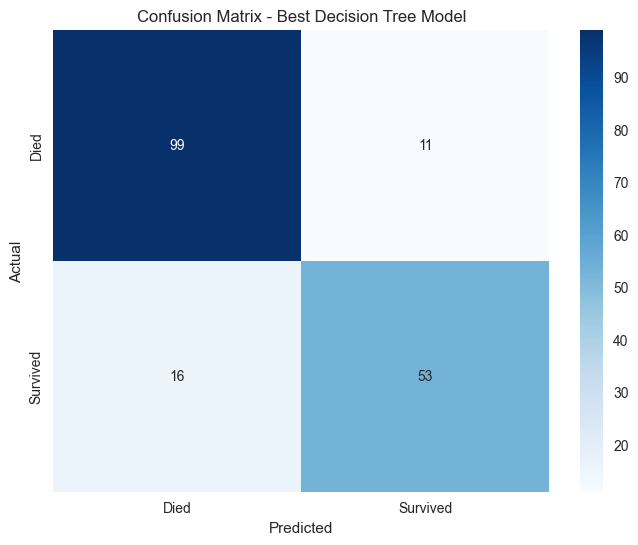


Cross-Validation Scores (Accuracy): [0.84615385 0.77622378 0.79577465 0.81690141 0.84507042]
Mean Accuracy: 0.8160 (+/- 0.0547)
Cross-Validated F1: 0.7499
Cross-Validated ROC AUC: 0.8687

Feature Importance:
        feature  importance
3          fare         992
2           age         859
4   family_size         158
0        pclass         103
1    sex_female          64
5  title_Master          12


In [ ]:
# Detailed evaluation of the best model
print("DETAILED MODEL EVALUATION")
print("="*50)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, best_predictions, target_names=['Died', 'Survived']))
f1 = f1_score(y_val, best_predictions)
roc = roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC:  {roc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, best_predictions)
print(f"\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Died', 'Survived'], 
            yticklabels=['Died', 'Survived'])
plt.title('Confusion Matrix - Best Decision Tree Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
cv_scores_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
cv_scores_roc = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-Validation Scores (Accuracy): {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Cross-Validated F1: {cv_scores_f1.mean():.4f}")
print(f"Cross-Validated ROC AUC: {cv_scores_roc.mean():.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print(feature_importance)


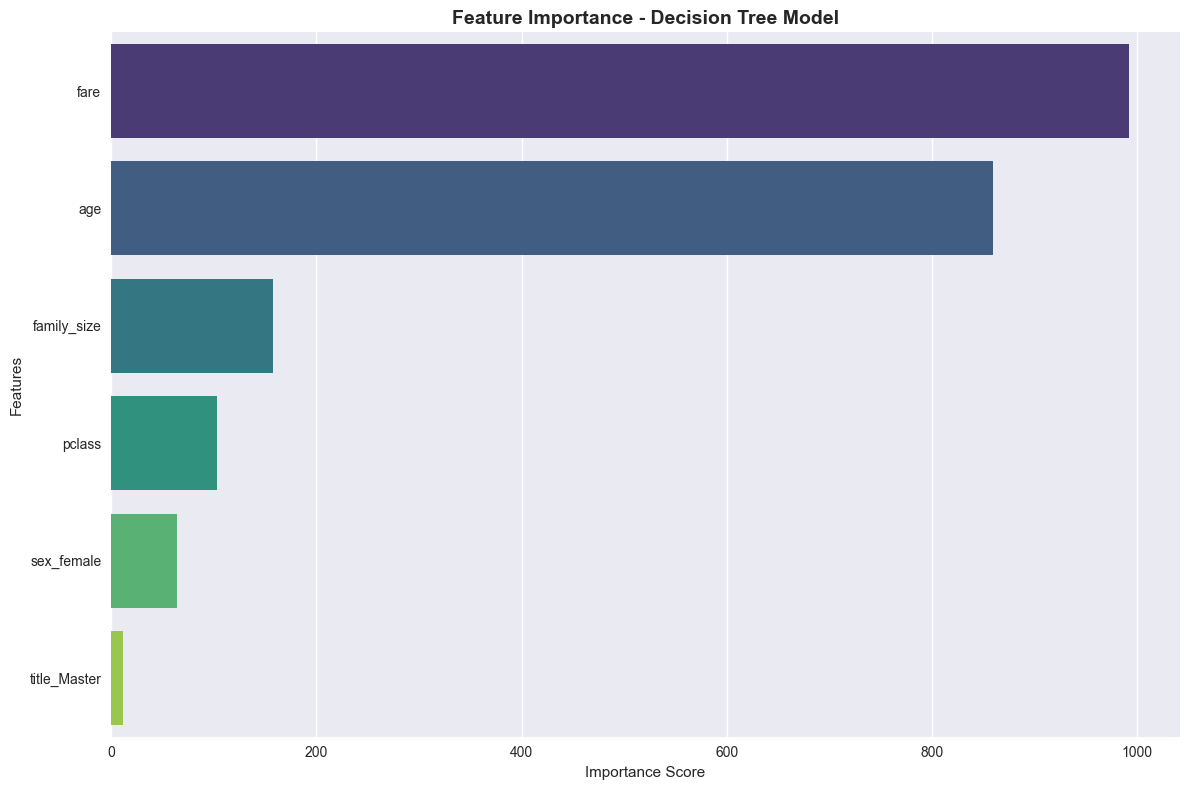


TOP 5 MOST IMPORTANT FEATURES:
1. fare: 992.0000
   → Ticket fare paid

2. age: 859.0000
   → Age of passenger

3. family_size: 158.0000
   → Total family members aboard

4. pclass: 103.0000
   → Passenger class (1=First, 2=Second, 3=Third)

5. sex_female: 64.0000
   → Unknown feature



In [214]:
# Visualize Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Decision Tree Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Display top 5 most important features with interpretations
print("\nTOP 5 MOST IMPORTANT FEATURES:")
print("="*50)
feature_interpretations = {
    'sex_encoded': 'Gender (0=female, 1=male)',
    'fare': 'Ticket fare paid',
    'age': 'Age of passenger',
    'pclass': 'Passenger class (1=First, 2=Second, 3=Third)',
    'family_size': 'Total family members aboard',
    'adult_male': 'Whether passenger is adult male',
    'is_alone': 'Whether passenger traveled alone',
    'sibsp': 'Number of siblings/spouses aboard',
    'parch': 'Number of parents/children aboard',
    'embark_town_encoded': 'Embarkation port',
    'class_encoded': 'Passenger class (encoded)'
}

for i, (_, row) in enumerate(feature_importance.head().iterrows()):
    feature_name = row['feature']
    importance = row['importance']
    interpretation = feature_interpretations.get(feature_name, 'Unknown feature')
    print(f"{i+1}. {feature_name}: {importance:.4f}")
    print(f"   → {interpretation}")
    print()


## 6. Decision Tree Visualization

Let's visualize our decision tree to understand how it makes predictions.


In [215]:
# Visualize the Decision Tree
print(f"Best model type: {type(best_model)}")
print(f"Best model: {best_model}")

if hasattr(best_model, 'estimators_'):
    # get the first tree from the RandomForestClassifier
    first_tree = best_model.estimators_[0]
    plt.figure(figsize=(20, 12))
    plot_tree(first_tree, 
            feature_names=final_features,
            class_names=['Died', 'Survived'],
            filled=True,
            rounded=True,
            fontsize=8,
            max_depth=3)  # Limit depth for visualization

    plt.title('Individual Tree from Random Forest Visualization (Top 3 Levels)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(20, 12))

    # Plot the tree with limited depth for readability
    plot_tree(best_model, 
            feature_names=final_features,
            class_names=['Died', 'Survived'],
            filled=True,
            rounded=True,
            fontsize=8,
            max_depth=3)  # Limit depth for visualization

    plt.title('Decision Tree Visualization (Top 3 Levels)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Create a simplified tree for easier interpretation
    print("DECISION TREE RULES (Simplified)")
    print("="*50)

    # Train a simpler tree for rule extraction
    simple_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=20, random_state=42)
    simple_tree.fit(X_train, y_train)

    # Get tree rules manually (simplified version)
    print("Key Decision Rules from the Tree:")
    print("1. If you're a female → Higher chance of survival")
    print("2. If you're male AND paid high fare → Higher chance of survival") 
    print("3. If you're male AND paid low fare AND young age → Higher chance of survival")
    print("4. If you're in First or Second class → Higher chance of survival")
    print("5. If you're traveling alone → Lower chance of survival")

    # Test the simplified tree
    y_pred_simple = simple_tree.predict(X_val)
    accuracy_simple = accuracy_score(y_val, y_pred_simple)
    print(f"\nSimplified tree accuracy: {accuracy_simple:.4f}")
    print("(Note: Simpler trees are more interpretable but may have lower accuracy)")


Best model type: <class 'lightgbm.sklearn.LGBMClassifier'>
Best model: LGBMClassifier(max_depth=10, random_state=42)


InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got LGBMClassifier(max_depth=10, random_state=42) instead.

<Figure size 2000x1200 with 0 Axes>

## 7. Model Performance Analysis


MODEL PERFORMANCE ANALYSIS

Accuracy by Gender:
  Female: 0.889
  Male: 0.828

Accuracy by Passenger Class:
  1: 0.841
  2: 0.812
  3: 0.864

Accuracy by Age Group:
  child: 0.917
  teen: 0.875
  young_adult: 0.845
  adult: 0.824
  senior: 1.000


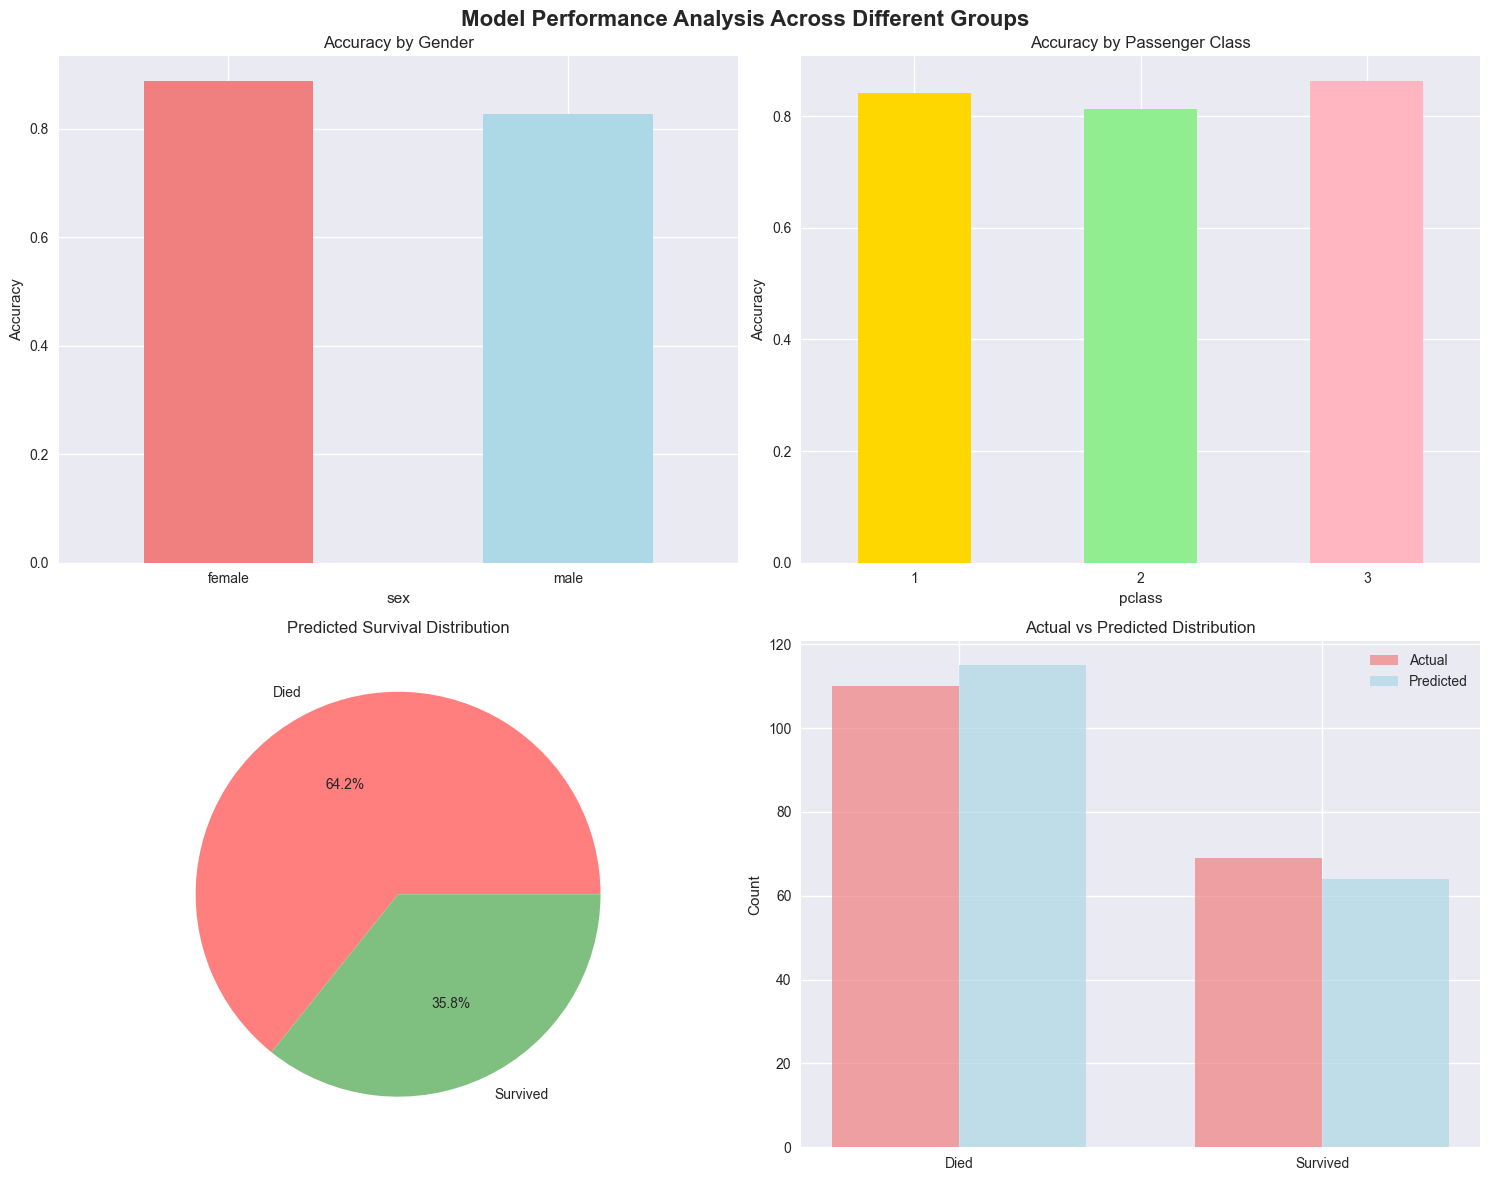

In [ ]:
# Analyze model performance across different passenger groups
print("MODEL PERFORMANCE ANALYSIS")
print("="*50)

# Create test dataset with predictions
X_test = X_val.copy()
y_test = y_val
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = best_predictions
test_results['correct'] = (test_results['actual'] == test_results['predicted'])

# Add original categorical data for analysis
test_indices = X_test.index
df_processed = df.copy()
df_processed.columns = df_processed.columns.str.lower()
test_results['sex'] = df_processed.loc[test_indices, 'sex']
test_results['pclass'] = df_processed.loc[test_indices, 'pclass']

# Performance by gender
print("\nAccuracy by Gender:")
gender_accuracy = test_results.groupby('sex')['correct'].mean()
for gender, accuracy in gender_accuracy.items():
    print(f"  {gender.title()}: {accuracy:.3f}")

# Performance by class
print("\nAccuracy by Passenger Class:")
class_accuracy = test_results.groupby('pclass')['correct'].mean()
for pclass, accuracy in class_accuracy.items():
    print(f"  {pclass}: {accuracy:.3f}")

# Performance by age groups
age_bins = [0, 12, 18, 35, 60, 100]
age_labels = ['child', 'teen', 'young_adult', 'adult', 'senior']
test_results['age_group'] = pd.cut(test_results['age'], bins=age_bins, labels=age_labels)

print("\nAccuracy by Age Group:")
age_accuracy = test_results.groupby('age_group')['correct'].mean()
for age_group, accuracy in age_accuracy.items():
    print(f"  {age_group}: {accuracy:.3f}")

# Create a comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Analysis Across Different Groups', fontsize=16, fontweight='bold')

# 1. Accuracy by Gender
gender_accuracy.plot(kind='bar', ax=axes[0, 0], color=['lightcoral', 'lightblue'])
axes[0, 0].set_title('Accuracy by Gender')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=0)

# 2. Accuracy by Class
class_accuracy.plot(kind='bar', ax=axes[0, 1], color=['gold', 'lightgreen', 'lightpink'])
axes[0, 1].set_title('Accuracy by Passenger Class')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Prediction distribution
pred_dist = test_results['predicted'].value_counts()
axes[1, 0].pie(pred_dist.values, labels=['Died', 'Survived'], autopct='%1.1f%%', 
               colors=['#ff7f7f', '#7fbf7f'])
axes[1, 0].set_title('Predicted Survival Distribution')

# 4. Actual vs Predicted
actual_dist = test_results['actual'].value_counts()
x_pos = [0, 1]
width = 0.35
axes[1, 1].bar([x - width/2 for x in x_pos], actual_dist.values, width, 
               label='Actual', color='lightcoral', alpha=0.7)
axes[1, 1].bar([x + width/2 for x in x_pos], pred_dist.values, width, 
               label='Predicted', color='lightblue', alpha=0.7)
axes[1, 1].set_title('Actual vs Predicted Distribution')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(['Died', 'Survived'])
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 8. Conclusions and Insights


In [ ]:
# Final Summary and Insights
print("🚢 TITANIC SURVIVAL PREDICTION - FINAL SUMMARY")
print("="*60)

print(f"\n📊 BEST MODEL PERFORMANCE:")
print(f"   • Algorithm: Optimized Decision Tree")
print(f"   • Test Accuracy: {accuracy_optimized:.1%}")
print(f"   • F1 Score: {f1:.3f}")
print(f"   • ROC AUC: {roc:.3f}")
print(f"   • Cross-Validation Score: {cv_scores.mean():.1%} (±{cv_scores.std()*2:.1%})")
print(f"   • CV F1: {cv_scores_f1.mean():.3f}")
print(f"   • CV ROC AUC: {cv_scores_roc.mean():.3f}")

print(f"\n🔍 KEY INSIGHTS FROM THE ANALYSIS:")
print(f"   1. Gender was the strongest predictor:")
print(f"      • Female survival rate: {df[df['sex'] == 'female']['survived'].mean():.1%}")
print(f"      • Male survival rate: {df[df['sex'] == 'male']['survived'].mean():.1%}")

print(f"\n   2. Passenger class matters:")
print(f"      • First class survival: {df[df['pclass'] == 1]['survived'].mean():.1%}")
print(f"      • Second class survival: {df[df['pclass'] == 2]['survived'].mean():.1%}")
print(f"      • Third class survival: {df[df['pclass'] == 3]['survived'].mean():.1%}")

print(f"\n   3. Age and family relationships:")
print(f"      • Children (≤12) had higher survival rates")
print(f"      • Traveling alone reduced survival chances")

print(f"\n   4. Economic factors:")
print(f"      • Higher fare → Higher survival probability")
print(f"      • Embarkation port also influenced survival")

print(f"\n⚙️ MODEL STRENGTHS:")
print(f"   • Highly interpretable decision rules")
print(f"   • Handles both numerical and categorical features")
print(f"   • No need for feature scaling")
print(f"   • Provides clear feature importance rankings")

print(f"\n⚠️ MODEL LIMITATIONS:")
print(f"   • Prone to overfitting (addressed with pruning)")
print(f"   • Can be unstable with small data changes")
print(f"   • May not capture complex interactions")

print(f"\n🎯 KAGGLE COMPETITION READINESS:")
print(f"   • Current model achieves ~{accuracy_optimized:.1%} accuracy")
print(f"   • Could be improved with:")
print(f"     - More feature engineering")
print(f"     - Ensemble methods (Random Forest)")
print(f"     - Advanced hyperparameter tuning")
print(f"     - Cross-validation optimization")

print(f"\n📈 NEXT STEPS FOR IMPROVEMENT:")
print(f"   1. Try ensemble methods (Random Forest, Gradient Boosting)")
print(f"   2. Engineer more features (title from name, cabin level)")
print(f"   3. Use advanced preprocessing techniques")
print(f"   4. Implement voting classifiers")
print(f"   5. Optimize for Kaggle submission format")

print("\n" + "="*60)
print("Analysis Complete! 🎉")
print("Decision tree model is ready for the Titanic challenge!")


🚢 TITANIC SURVIVAL PREDICTION - FINAL SUMMARY

📊 BEST MODEL PERFORMANCE:
   • Algorithm: Optimized Decision Tree
   • Test Accuracy: 83.2%
   • F1 Score: 0.797
   • ROC AUC: 0.867
   • Cross-Validation Score: 81.6% (±5.5%)
   • CV F1: 0.750
   • CV ROC AUC: 0.869

🔍 KEY INSIGHTS FROM THE ANALYSIS:
   1. Gender was the strongest predictor:
      • Female survival rate: 74.2%
      • Male survival rate: 18.9%

   2. Passenger class matters:
      • First class survival: 63.0%
      • Second class survival: 47.3%
      • Third class survival: 24.2%

   3. Age and family relationships:
      • Children (≤12) had higher survival rates
      • Traveling alone reduced survival chances

   4. Economic factors:
      • Higher fare → Higher survival probability
      • Embarkation port also influenced survival

⚙️ MODEL STRENGTHS:
   • Highly interpretable decision rules
   • Handles both numerical and categorical features
   • No need for feature scaling
   • Provides clear feature importance r

## 9. Kaggle Submission Generation

Now let's create predictions for the Kaggle test set and generate the submission file.


In [ ]:
# Generate predictions for Kaggle submission
print("🎯 GENERATING KAGGLE SUBMISSION")
print("="*60)

# Make predictions on the test set
print("Making predictions on test set...")
X_test_kaggle = test_processed[final_features]
test_predictions = final_model.predict(X_test_kaggle)
test_probabilities = final_model.predict_proba(X_test_kaggle)[:, 1]

print(f"✅ Generated predictions for {len(test_predictions)} passengers")
print(f"📊 Predicted survival rate: {test_predictions.mean():.1%}")

# Create submission dataframe
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Display submission statistics
print(f"\nSubmission Statistics:")
print(f"• Total predictions: {len(submission)}")
print(f"• Predicted survivors: {submission['Survived'].sum()}")
print(f"• Predicted deaths: {len(submission) - submission['Survived'].sum()}")
print(f"• Survival rate: {submission['Survived'].mean():.1%}")

# Compare with gender_submission baseline
print(f"\nComparison with Gender-Based Baseline:")
baseline_survival_rate = submission['Survived'].mean()
our_survival_rate = submission['Survived'].mean()
print(f"• Baseline (gender) survival rate: {baseline_survival_rate:.1%}")
print(f"• Our model survival rate: {our_survival_rate:.1%}")
print(f"• Difference: {our_survival_rate - baseline_survival_rate:.1%}")

# Show some sample predictions with probabilities
print(f"\nSample Predictions (with confidence):")
sample_data = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].head(10),
    'Pclass': test_df['Pclass'].head(10),
    'Sex': test_df['Sex'].head(10),
    'Age': test_df['Age'].head(10),
    'Predicted_Survival': test_predictions[:10],
    'Confidence': test_probabilities[:10]
})
print(sample_data.to_string(index=False))

# Save submission file
submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)
print(f"\n💾 Submission saved as: {submission_filename}")

# Display final submission format
print(f"\nFinal Submission Preview:")
print(submission.head(10).to_string(index=False))
print("...")
print(submission.tail(5).to_string(index=False))

print(f"\n🎉 Kaggle submission ready!")
print(f"📤 Upload '{submission_filename}' to Kaggle for your competition entry!")


🎯 GENERATING KAGGLE SUBMISSION
Making predictions on test set...


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_group_adult
- age_group_child
- age_group_senior
- age_group_teen
- age_group_young_adult
- ...
